<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Single Stock Fundamental

# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Train DRL Agent](#5)  
* [7.Backtest Our Strategy](#6)  
    * [7.1. BackTest with DJIA](#6.1)
    * [7.2. BackTest with Buy&Hold Strategy](#6.2)          

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
# ## install finrl library
# !pip install wrds
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
from stable_baselines3.common.logger import configure

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [6]:
test_ticket = ['AAPL']

In [7]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2019-01-01'
TEST_START_DATE = '2019-01-01'
TEST_END_DATE = '2021-01-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = test_ticket).fetch_data()

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (3021, 8)


In [8]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.743889,746015200,AAPL,4
1,2009-01-05,3.327500,3.435000,3.311071,2.859692,1181608400,AAPL,0
2,2009-01-06,3.426786,3.470357,3.299643,2.812524,1289310400,AAPL,1
3,2009-01-07,3.278929,3.303571,3.223571,2.751750,753048800,AAPL,2
4,2009-01-08,3.229643,3.326786,3.215714,2.802849,673500800,AAPL,3


In [9]:
df.tail()

,date,open,high,low,close,volume,tic,day
3016,2020-12-24,131.320007,133.460007,131.100006,129.514435,54930100,AAPL,3
3017,2020-12-28,133.990005,137.339996,133.509995,134.146652,124486200,AAPL,0
3018,2020-12-29,138.050003,138.789993,134.339996,132.360489,121047300,AAPL,1
3019,2020-12-30,135.580002,135.990005,133.399994,131.231918,96452100,AAPL,2
3020,2020-12-31,134.080002,134.740005,131.720001,130.221085,99116600,AAPL,3


In [10]:
df.shape

(3021, 8)

In [11]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.743889,746015200,AAPL,4
1,2009-01-05,3.327500,3.435000,3.311071,2.859692,1181608400,AAPL,0
2,2009-01-06,3.426786,3.470357,3.299643,2.812524,1289310400,AAPL,1
3,2009-01-07,3.278929,3.303571,3.223571,2.751750,753048800,AAPL,2
4,2009-01-08,3.229643,3.326786,3.215714,2.802849,673500800,AAPL,3


In [12]:
len(df.tic.unique())

1

In [13]:
df.tic.value_counts()

tic
AAPL    3021
Name: count, dtype: int64

<a id='3'></a>
# Part 4: Preprocess fundamental data
- Import finanical data downloaded from Compustat via WRDS(Wharton Research Data Service)
- Preprocess the dataset and calculate financial ratios
- Add those ratios to the price data preprocessed in Part 3
- Calculate price-related ratios such as P/E and P/B

<a id='3.1'></a>
## 4.1 Import the financial data

In [14]:
# Import fundamental data from my GitHub repository
url = 'https://raw.githubusercontent.com/mariko-sawada/FinRL_with_fundamental_data/main/dow_30_fundamental_wrds.csv'

fund = pd.read_csv(url)
fund = fund[fund.tic == test_ticket[0]]

In [15]:
# Check the imported dataset
fund.head()

,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,tic,...,dvpsxq,mkvaltq,prccq,prchq,prclq,adjex,ggroup,gind,gsector,gsubind
88,1690,19990630,1999,3,9,INDL,C,D,STD,AAPL,...,0.0,NaN,46.3125,50.000,33.5000,112.0,4520,452020,45,45202030
89,1690,19990930,1999,4,9,INDL,C,D,STD,AAPL,...,0.0,NaN,63.3125,80.125,45.1875,112.0,4520,452020,45,45202030
90,1690,19991231,2000,1,9,INDL,C,D,STD,AAPL,...,0.0,NaN,102.8125,118.000,59.5000,112.0,4520,452020,45,45202030
91,1690,20000331,2000,2,9,INDL,C,D,STD,AAPL,...,0.0,NaN,135.8125,150.375,86.5000,112.0,4520,452020,45,45202030
92,1690,20000630,2000,3,9,INDL,C,D,STD,AAPL,...,0.0,NaN,52.3750,69.750,40.1875,56.0,4520,452020,45,45202030


In [16]:
fund.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88 entries, 88 to 175
Columns: 647 entries, gvkey to gsubind
dtypes: float64(617), int64(12), object(18)
memory usage: 445.5+ KB


<a id='3.2'></a>
## 4.2 Specify items needed to calculate financial ratios
- To learn more about the data description of the dataset, please check WRDS's website(https://wrds-www.wharton.upenn.edu/). Login will be required.

In [17]:
# List items that are used to calculate financial ratios

items = [
    'datadate', # Date
    'tic', # Ticker
    'oiadpq', # Quarterly operating income
    'revtq', # Quartely revenue
    'niq', # Quartely net income
    'atq', # Total asset
    'teqq', # Shareholder's equity
    'epspiy', # EPS(Basic) incl. Extraordinary items
    'ceqq', # Common Equity
    'cshoq', # Common Shares Outstanding
    'dvpspq', # Dividends per share
    'actq', # Current assets
    'lctq', # Current liabilities
    'cheq', # Cash & Equivalent
    'rectq', # Recievalbles
    'cogsq', # Cost of  Goods Sold
    'invtq', # Inventories
    'apq',# Account payable
    'dlttq', # Long term debt
    'dlcq', # Debt in current liabilites
    'ltq' # Liabilities   
]

# Omit items that will not be used
fund_data = fund[items]

In [18]:
# Rename column names for the sake of readability
fund_data = fund_data.rename(columns={
    'datadate':'date', # Date
    'oiadpq':'op_inc_q', # Quarterly operating income
    'revtq':'rev_q', # Quartely revenue
    'niq':'net_inc_q', # Quartely net income
    'atq':'tot_assets', # Assets
    'teqq':'sh_equity', # Shareholder's equity
    'epspiy':'eps_incl_ex', # EPS(Basic) incl. Extraordinary items
    'ceqq':'com_eq', # Common Equity
    'cshoq':'sh_outstanding', # Common Shares Outstanding
    'dvpspq':'div_per_sh', # Dividends per share
    'actq':'cur_assets', # Current assets
    'lctq':'cur_liabilities', # Current liabilities
    'cheq':'cash_eq', # Cash & Equivalent
    'rectq':'receivables', # Receivalbles
    'cogsq':'cogs_q', # Cost of  Goods Sold
    'invtq':'inventories', # Inventories
    'apq': 'payables',# Account payable
    'dlttq':'long_debt', # Long term debt
    'dlcq':'short_debt', # Debt in current liabilites
    'ltq':'tot_liabilities' # Liabilities   
})

In [19]:
# Check the data
fund_data.date = pd.to_datetime(fund_data['date'],format='%Y%m%d')
fund_data.sort_values('date')
fund_data.head()

,date,tic,op_inc_q,rev_q,net_inc_q,tot_assets,sh_equity,eps_incl_ex,com_eq,sh_outstanding,...,cur_assets,cur_liabilities,cash_eq,receivables,cogs_q,inventories,payables,long_debt,short_debt,tot_liabilities
88,1999-06-30,AAPL,104.0,1558.0,203.0,5019.0,NaN,3.54,2820.0,160.127,...,4298.0,1539.0,3106.0,896.0,1112.0,7.0,792.0,300.0,0.0,2049.0
89,1999-09-30,AAPL,67.0,1336.0,111.0,5161.0,NaN,4.20,2954.0,160.799,...,4285.0,1549.0,3226.0,681.0,933.0,20.0,812.0,300.0,0.0,2057.0
90,1999-12-31,AAPL,198.0,2343.0,183.0,7586.0,NaN,1.14,4264.0,161.224,...,4909.0,1965.0,3660.0,892.0,1716.0,15.0,1174.0,300.0,0.0,3172.0
91,2000-03-31,AAPL,170.0,1945.0,233.0,7007.0,NaN,2.57,4065.0,162.680,...,4912.0,1853.0,3609.0,940.0,1375.0,10.0,1111.0,300.0,0.0,2792.0
92,2000-06-30,AAPL,168.0,1825.0,200.0,6932.0,NaN,1.90,4026.0,324.826,...,5157.0,1873.0,3826.0,967.0,1257.0,5.0,1040.0,300.0,0.0,2756.0


<a id='3.3'></a>
## 4.3 Feature engineering
Data cleaning for fundamental data points before calculating financial ratios ensures accurate financial analysis by: 
- Addressing missing values through imputation or removal,
- Identifying and handling outliers through winsorization or careful removal,
- Standardizing data format for consistency (dates, units, currency),
- Correcting errors like typos and inconsistencies,
- Checking for duplicate values to avoid inflated figures.

In [20]:
fund_data.reset_index(drop=True, inplace=True)
fund_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             88 non-null     datetime64[ns]
 1   tic              88 non-null     object        
 2   op_inc_q         88 non-null     float64       
 3   rev_q            88 non-null     float64       
 4   net_inc_q        88 non-null     float64       
 5   tot_assets       88 non-null     float64       
 6   sh_equity        50 non-null     float64       
 7   eps_incl_ex      88 non-null     float64       
 8   com_eq           88 non-null     float64       
 9   sh_outstanding   88 non-null     float64       
 10  div_per_sh       88 non-null     float64       
 11  cur_assets       88 non-null     float64       
 12  cur_liabilities  88 non-null     float64       
 13  cash_eq          88 non-null     float64       
 14  receivables      88 non-null     float64    

In [21]:
fund_data.isna().sum()

date                0
tic                 0
op_inc_q            0
rev_q               0
net_inc_q           0
tot_assets          0
sh_equity          38
eps_incl_ex         0
com_eq              0
sh_outstanding      0
div_per_sh          0
cur_assets          0
cur_liabilities     0
cash_eq             0
receivables         0
cogs_q              0
inventories         0
payables            0
long_debt           0
short_debt          0
tot_liabilities     0
dtype: int64

**sh_equity** having the highest missing values compared to other fundamental data points.
We need to investigate the cause of the missing values in these specific accounts.

#### Data cleaning: **sh_equity**

In [22]:
fund_data[fund_data['sh_equity'].isnull()][['date','sh_equity']]

,date,sh_equity
0,1999-06-30,NaN
1,1999-09-30,NaN
2,1999-12-31,NaN
3,2000-03-31,NaN
4,2000-06-30,NaN
5,2000-09-30,NaN
6,2000-12-31,NaN
7,2001-03-31,NaN
8,2001-06-30,NaN
9,2001-09-30,NaN


The number of shares, sh_equity column, appears to be updated whenever there are changed. We need to investigate this column futher to understand the updating behaviour in more detail.

In [23]:
fund_data[['date','sh_equity']]

,date,sh_equity
0,1999-06-30,NaN
1,1999-09-30,NaN
2,1999-12-31,NaN
3,2000-03-31,NaN
4,2000-06-30,NaN
...,...,...
83,2020-03-31,78425.0
84,2020-06-30,72282.0
85,2020-09-30,65339.0
86,2020-12-31,66224.0


Our analysis suspects that duplicated data entries within the same date. We can safely remove these duplicated rows, focusing on those with null values in the 'number of shares' column

In [24]:
check_date_dup = fund_data.date.duplicated()
check_date_dup = fund_data.iloc[check_date_dup[check_date_dup==True].index]
check_date_dup = check_date_dup[check_date_dup.sh_equity.isnull()]
fund_data.drop(check_date_dup.index,inplace=True)

To ensure consistency across quaters, only date values with months corresponding to quater ends (3, 6, 9,and 12) are accepted

In [25]:
check_month = fund_data.date.dt.month
check_year = fund_data.date.dt.year
dummy_value = pd.DataFrame([1 for i in range(len(fund_data))])
check_pivot = pd.concat([check_month,check_year,dummy_value],axis=1)
check_pivot.columns = ['month','year','value']
pivot_table = pd.pivot_table(check_pivot,columns='month',index='year',aggfunc=np.sum)
pivot_table

value               
month    3    6    9    12
year                      
1999    NaN  1.0  1.0  1.0
2000    1.0  1.0  1.0  1.0
2001    1.0  1.0  1.0  1.0
2002    1.0  1.0  1.0  1.0
2003    1.0  1.0  1.0  1.0
2004    1.0  1.0  1.0  1.0
2005    1.0  1.0  1.0  1.0
2006    1.0  1.0  1.0  1.0
2007    1.0  1.0  1.0  1.0
2008    1.0  1.0  1.0  1.0
2009    1.0  1.0  1.0  1.0
2010    1.0  1.0  1.0  1.0
2011    1.0  1.0  1.0  1.0
2012    1.0  1.0  1.0  1.0
2013    1.0  1.0  1.0  1.0
2014    1.0  1.0  1.0  1.0
2015    1.0  1.0  1.0  1.0
2016    1.0  1.0  1.0  1.0
2017    1.0  1.0  1.0  1.0
2018    1.0  1.0  1.0  1.0
2019    1.0  1.0  1.0  1.0
2020    1.0  1.0  1.0  1.0
2021    1.0  NaN  NaN  NaN

#### Adjust quaterly data
While the fundametal data is provided daily, this frequency differ from real market where the companies typically record their performance monthly or quarterly. 
To address it, we will refine the data to reflect the quarter end and infer the daily values using a regression model

In [26]:
grouped_df = fund_data.copy()
grouped_df['year'] = grouped_df.date.dt.year
grouped_df['month'] = grouped_df.date.dt.month
grouped_df = grouped_df.groupby(['tic','year','month']).mean(numeric_only=True).reset_index()
grouped_df

,tic,year,month,op_inc_q,rev_q,net_inc_q,tot_assets,sh_equity,eps_incl_ex,com_eq,...,cur_assets,cur_liabilities,cash_eq,receivables,cogs_q,inventories,payables,long_debt,short_debt,tot_liabilities
0,AAPL,1999,6,104.0,1558.0,203.0,5019.0,NaN,3.54,2820.0,...,4298.0,1539.0,3106.0,896.0,1112.0,7.0,792.0,300.0,0.0,2049.0
1,AAPL,1999,9,67.0,1336.0,111.0,5161.0,NaN,4.20,2954.0,...,4285.0,1549.0,3226.0,681.0,933.0,20.0,812.0,300.0,0.0,2057.0
2,AAPL,1999,12,198.0,2343.0,183.0,7586.0,NaN,1.14,4264.0,...,4909.0,1965.0,3660.0,892.0,1716.0,15.0,1174.0,300.0,0.0,3172.0
3,AAPL,2000,3,170.0,1945.0,233.0,7007.0,NaN,2.57,4065.0,...,4912.0,1853.0,3609.0,940.0,1375.0,10.0,1111.0,300.0,0.0,2792.0
4,AAPL,2000,6,168.0,1825.0,200.0,6932.0,NaN,1.90,4026.0,...,5157.0,1873.0,3826.0,967.0,1257.0,5.0,1040.0,300.0,0.0,2756.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,AAPL,2020,3,12853.0,58313.0,11249.0,320400.0,78425.0,7.63,78425.0,...,143753.0,96094.0,95128.0,30677.0,33157.0,3334.0,32421.0,97136.0,21625.0,241975.0
84,AAPL,2020,6,13091.0,59685.0,11253.0,317344.0,72282.0,10.25,72282.0,...,140065.0,95318.0,93054.0,32075.0,34253.0,3978.0,35325.0,102138.0,20048.0,245062.0
85,AAPL,2020,9,14775.0,64698.0,12673.0,323888.0,65339.0,3.31,65339.0,...,143713.0,105392.0,90979.0,37445.0,37307.0,4061.0,42296.0,107049.0,15229.0,258549.0
86,AAPL,2020,12,33534.0,111439.0,28755.0,354054.0,66224.0,1.70,66224.0,...,154106.0,132507.0,76826.0,58620.0,64445.0,4973.0,63846.0,99281.0,12762.0,287830.0


In [27]:
start_year = int(grouped_df.iloc[0].year)
start_month = int(grouped_df.iloc[0].month)
end_year = int(grouped_df.iloc[-1].year)
end_month = int(grouped_df.iloc[-1].month)
date_range = pd.date_range(start=f"{start_year}-{start_month:02d}-01", 
                           end=f"{end_year}-{end_month:02d}-01", 
                           freq='D')
date_range = pd.DataFrame(date_range)
date_range.columns = ['date']
date_range.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7945 entries, 0 to 7944
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    7945 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 62.2 KB


In [28]:
grouped_df['date'] = grouped_df.apply(lambda x: pd.to_datetime(f"{int(x.year)}-{int(x.month):02d}-01"),axis=1)

In [29]:
grouped_df = pd.merge(date_range,grouped_df,how='left')
grouped_df.drop(columns=['year','month'],inplace=True)
grouped_df.tic.bfill(inplace=True)
grouped_df

,date,tic,op_inc_q,rev_q,net_inc_q,tot_assets,sh_equity,eps_incl_ex,com_eq,sh_outstanding,...,cur_assets,cur_liabilities,cash_eq,receivables,cogs_q,inventories,payables,long_debt,short_debt,tot_liabilities
0,1999-06-01,AAPL,104.0,1558.0,203.0,5019.0,NaN,3.54,2820.0,160.127,...,4298.0,1539.0,3106.0,896.0,1112.0,7.0,792.0,300.0,0.0,2049.0
1,1999-06-02,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1999-06-03,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1999-06-04,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1999-06-05,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7940,2021-02-25,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7941,2021-02-26,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7942,2021-02-27,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7943,2021-02-28,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
grouped_df.interpolate(method='linear', limit_direction='forward', axis=0,inplace=True)
grouped_df

,date,tic,op_inc_q,rev_q,net_inc_q,tot_assets,sh_equity,eps_incl_ex,com_eq,sh_outstanding,...,cur_assets,cur_liabilities,cash_eq,receivables,cogs_q,inventories,payables,long_debt,short_debt,tot_liabilities
0,1999-06-01,AAPL,104.000000,1558.000000,203.000000,5019.000000,NaN,3.540000,2820.000000,160.127000,...,4298.000000,1539.000000,3106.000000,896.000000,1112.000000,7.000000,792.000000,300.000000,0.000000,2049.000000
1,1999-06-02,AAPL,103.597826,1555.586957,202.000000,5020.543478,NaN,3.547174,2821.456522,160.134304,...,4297.858696,1539.108696,3107.304348,893.663043,1110.054348,7.141304,792.217391,300.000000,0.000000,2049.086957
2,1999-06-03,AAPL,103.195652,1553.173913,201.000000,5022.086957,NaN,3.554348,2822.913043,160.141609,...,4297.717391,1539.217391,3108.608696,891.326087,1108.108696,7.282609,792.434783,300.000000,0.000000,2049.173913
3,1999-06-04,AAPL,102.793478,1550.760870,200.000000,5023.630435,NaN,3.561522,2824.369565,160.148913,...,4297.576087,1539.326087,3109.913043,888.989130,1106.163043,7.423913,792.652174,300.000000,0.000000,2049.260870
4,1999-06-05,AAPL,102.391304,1548.347826,199.000000,5025.173913,NaN,3.568696,2825.826087,160.156217,...,4297.434783,1539.434783,3111.217391,886.652174,1104.217391,7.565217,792.869565,300.000000,0.000000,2049.347826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7940,2021-02-25,AAPL,27771.044444,90555.333333,23857.777778,337908.933333,69046.711111,3.047333,69046.711111,16692.392022,...,122915.711111,107545.977778,70144.755556,34173.066667,49407.422222,5208.066667,41181.177778,108225.955556,12992.288889,268862.222222
7941,2021-02-26,AAPL,27704.033333,90312.500000,23800.833333,337721.200000,69079.533333,3.063000,69079.533333,16690.870267,...,122553.033333,107255.733333,70067.066667,33888.800000,49232.566667,5210.800000,40917.633333,108329.966667,12994.966667,268641.666667
7942,2021-02-27,AAPL,27637.022222,90069.666667,23743.888889,337533.466667,69112.355556,3.078667,69112.355556,16689.348511,...,122190.355556,106965.488889,69989.377778,33604.533333,49057.711111,5213.533333,40654.088889,108433.977778,12997.644444,268421.111111
7943,2021-02-28,AAPL,27570.011111,89826.833333,23686.944444,337345.733333,69145.177778,3.094333,69145.177778,16687.826756,...,121827.677778,106675.244444,69911.688889,33320.266667,48882.855556,5216.266667,40390.544444,108537.988889,13000.322222,268200.555556


Our feature engineering reveals that **sh_equity** data is missing from 2008-09-30 onward. This could potentially be due to the stock's listing date. Assuming the stock's price remained constant before the listing date, **backfilling** appears to be the most suitable solution

In [31]:
grouped_df.bfill(inplace=True)

In [32]:
fund_data = grouped_df

In [33]:
fund_data

,date,tic,op_inc_q,rev_q,net_inc_q,tot_assets,sh_equity,eps_incl_ex,com_eq,sh_outstanding,...,cur_assets,cur_liabilities,cash_eq,receivables,cogs_q,inventories,payables,long_debt,short_debt,tot_liabilities
0,1999-06-01,AAPL,104.000000,1558.000000,203.000000,5019.000000,22909.000000,3.540000,2820.000000,160.127000,...,4298.000000,1539.000000,3106.000000,896.000000,1112.000000,7.000000,792.000000,300.000000,0.000000,2049.000000
1,1999-06-02,AAPL,103.597826,1555.586957,202.000000,5020.543478,22909.000000,3.547174,2821.456522,160.134304,...,4297.858696,1539.108696,3107.304348,893.663043,1110.054348,7.141304,792.217391,300.000000,0.000000,2049.086957
2,1999-06-03,AAPL,103.195652,1553.173913,201.000000,5022.086957,22909.000000,3.554348,2822.913043,160.141609,...,4297.717391,1539.217391,3108.608696,891.326087,1108.108696,7.282609,792.434783,300.000000,0.000000,2049.173913
3,1999-06-04,AAPL,102.793478,1550.760870,200.000000,5023.630435,22909.000000,3.561522,2824.369565,160.148913,...,4297.576087,1539.326087,3109.913043,888.989130,1106.163043,7.423913,792.652174,300.000000,0.000000,2049.260870
4,1999-06-05,AAPL,102.391304,1548.347826,199.000000,5025.173913,22909.000000,3.568696,2825.826087,160.156217,...,4297.434783,1539.434783,3111.217391,886.652174,1104.217391,7.565217,792.869565,300.000000,0.000000,2049.347826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7940,2021-02-25,AAPL,27771.044444,90555.333333,23857.777778,337908.933333,69046.711111,3.047333,69046.711111,16692.392022,...,122915.711111,107545.977778,70144.755556,34173.066667,49407.422222,5208.066667,41181.177778,108225.955556,12992.288889,268862.222222
7941,2021-02-26,AAPL,27704.033333,90312.500000,23800.833333,337721.200000,69079.533333,3.063000,69079.533333,16690.870267,...,122553.033333,107255.733333,70067.066667,33888.800000,49232.566667,5210.800000,40917.633333,108329.966667,12994.966667,268641.666667
7942,2021-02-27,AAPL,27637.022222,90069.666667,23743.888889,337533.466667,69112.355556,3.078667,69112.355556,16689.348511,...,122190.355556,106965.488889,69989.377778,33604.533333,49057.711111,5213.533333,40654.088889,108433.977778,12997.644444,268421.111111
7943,2021-02-28,AAPL,27570.011111,89826.833333,23686.944444,337345.733333,69145.177778,3.094333,69145.177778,16687.826756,...,121827.677778,106675.244444,69911.688889,33320.266667,48882.855556,5216.266667,40390.544444,108537.988889,13000.322222,268200.555556


<a id='3.4'></a>
## 4.4 Calculate financial ratios
- For items from Profit/Loss statements, we calculate LTM (Last Twelve Months) and use them to derive profitability related ratios such as Operating Maring and ROE. For items from balance sheets, we use the numbers on the day.
- To check the definitions of the financial ratios calculated here, please refer to CFI's website: https://corporatefinanceinstitute.com/resources/knowledge/finance/financial-ratios/

In [34]:
# Calculate financial ratios
date = pd.to_datetime(grouped_df['date'],format='%Y%m%d')

tic = fund_data['tic'].to_frame('tic')

# Profitability ratios
# Operating Margin
OPM = (grouped_df['op_inc_q']/grouped_df['rev_q']).to_frame('OPM')

# Net Profit Margin        
NPM = (grouped_df['net_inc_q']/grouped_df['rev_q']).to_frame('NPM')

# Return On Assets
ROA = (grouped_df['net_inc_q']/grouped_df['tot_assets']).to_frame('ROA')

# Return on Equity
ROE = (grouped_df['net_inc_q']/grouped_df['sh_equity']).to_frame('ROE')

# For calculating valuation ratios in the next subpart, calculate per-share items in advance
# Earnings Per Share       
EPS = grouped_df['eps_incl_ex'].to_frame('EPS')

# Book Per Share
BPS = (grouped_df['com_eq']/grouped_df['sh_outstanding']).to_frame('BPS')

#Dividend Per Share
DPS = grouped_df['div_per_sh'].to_frame('DPS')

# Liquidity ratios
# Current ratio
cur_ratio = (grouped_df['cur_assets']/grouped_df['cur_liabilities']).to_frame('cur_ratio')

# Quick ratio
quick_ratio = ((grouped_df['cash_eq'] + grouped_df['receivables'] )/grouped_df['cur_liabilities']).to_frame('quick_ratio')

# Cash ratio
cash_ratio = (grouped_df['cash_eq']/grouped_df['cur_liabilities']).to_frame('cash_ratio')


# Efficiency ratios
# Inventory turnover ratio
inv_turnover = (grouped_df['cogs_q']/grouped_df['inventories']).to_frame('inv_turnover')

# Receivables turnover ratio       
acc_rec_turnover = (grouped_df['rev_q']/grouped_df['receivables']).to_frame('acc_rec_turnover')

# Payable turnover ratio
acc_pay_turnover = (grouped_df['cogs_q']/grouped_df['payables']).to_frame('acc_pay_turnover')
        
## Leverage financial ratios
# Debt ratio
debt_ratio = (fund_data['tot_liabilities']/fund_data['tot_assets']).to_frame('debt_ratio')

# Debt to Equity ratio
debt_to_equity = (fund_data['tot_liabilities']/fund_data['sh_equity']).to_frame('debt_to_equity')

In [35]:
# Create a dataframe that merges all the ratios
ratios = pd.concat([date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,
                    cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,
                   debt_ratio,debt_to_equity], axis=1)

In [36]:
# Check the ratio data
ratios.head()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
0,1999-06-01,AAPL,0.066752,0.130295,0.040446,0.008861,3.540000,17.611021,0.0,2.792723,2.600390,2.018194,158.857143,1.738839,1.404040,0.408249,0.089441
1,1999-06-02,AAPL,0.066597,0.129855,0.040235,0.008817,3.547174,17.619314,0.0,2.792434,2.599535,2.018899,155.441400,1.740686,1.401199,0.408140,0.089445
2,1999-06-03,AAPL,0.066442,0.129412,0.040023,0.008774,3.554348,17.627605,0.0,2.792145,2.598681,2.019603,152.158209,1.742543,1.398359,0.408032,0.089448
3,1999-06-04,AAPL,0.066286,0.128969,0.039812,0.008730,3.561522,17.635896,0.0,2.791856,2.597827,2.020308,149.000000,1.744409,1.395521,0.407924,0.089452
4,1999-06-05,AAPL,0.066129,0.128524,0.039601,0.008687,3.568696,17.644186,0.0,2.791567,2.596972,2.021013,145.959770,1.746285,1.392685,0.407816,0.089456


In [37]:
ratios.tail()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
7940,2021-02-25,AAPL,0.306675,0.263461,0.070604,0.345531,3.047333,4.136418,0.205,1.142913,0.969983,0.652230,9.486711,2.649904,1.199757,0.795665,3.893918
7941,2021-02-26,AAPL,0.306757,0.263539,0.070475,0.344542,3.063000,4.138762,0.205,1.142625,0.969234,0.653271,9.448178,2.664966,1.203211,0.795454,3.888875
7942,2021-02-27,AAPL,0.306841,0.263617,0.070345,0.343555,3.078667,4.141106,0.205,1.142334,0.968480,0.654317,9.409686,2.680283,1.206710,0.795243,3.883837
7943,2021-02-28,AAPL,0.306924,0.263696,0.070216,0.342568,3.094333,4.143450,0.205,1.142043,0.967722,0.655369,9.371234,2.695862,1.210255,0.795032,3.878803
7944,2021-03-01,AAPL,0.307008,0.263775,0.070086,0.341583,3.110000,4.145795,0.205,1.141749,0.966960,0.656427,9.332822,2.711708,1.213846,0.794820,3.873775


<a id='3.5'></a>
## 4.5 Deal with NAs and infinite values
After our initial inspection, we’ll want to dig deeper to investigate the following:
- The data type of each variable.
- How discrete/categorical data is coded (and whether we need to make any changes).
- How the data are scaled.
- Whether there is missing data and how it is coded.
- Whether there are outliers.
- The distributions of continuous features.
- The relationships between pairs of features.

### Data types
It is important to check the data type for each feature. 
The ratios should be read in as float64 — and categorical variables should be stored as object 

In [38]:
ratios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7945 entries, 0 to 7944
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              7945 non-null   datetime64[ns]
 1   tic               7945 non-null   object        
 2   OPM               7945 non-null   float64       
 3   NPM               7945 non-null   float64       
 4   ROA               7945 non-null   float64       
 5   ROE               7945 non-null   float64       
 6   EPS               7945 non-null   float64       
 7   BPS               7945 non-null   float64       
 8   DPS               7945 non-null   float64       
 9   cur_ratio         7945 non-null   float64       
 10  quick_ratio       7945 non-null   float64       
 11  cash_ratio        7945 non-null   float64       
 12  inv_turnover      7945 non-null   float64       
 13  acc_rec_turnover  7945 non-null   float64       
 14  acc_pay_turnover  7945 n

In [39]:
ratios.isna().sum()

date                0
tic                 0
OPM                 0
NPM                 0
ROA                 0
ROE                 0
EPS                 0
BPS                 0
DPS                 0
cur_ratio           0
quick_ratio         0
cash_ratio          0
inv_turnover        0
acc_rec_turnover    0
acc_pay_turnover    0
debt_ratio          0
debt_to_equity      0
dtype: int64

We see that there is no missing values in all ratios

In [40]:
ratios.dtypes

date                datetime64[ns]
tic                         object
OPM                        float64
NPM                        float64
ROA                        float64
ROE                        float64
EPS                        float64
BPS                        float64
DPS                        float64
cur_ratio                  float64
quick_ratio                float64
cash_ratio                 float64
inv_turnover               float64
acc_rec_turnover           float64
acc_pay_turnover           float64
debt_ratio                 float64
debt_to_equity             float64
dtype: object

Since we have both continuous (float64) and categorical (object) variables in our data, it might be informative to look at the number of unique values in each column using the nunique() function.

In [41]:
ratios.nunique()

date                7945
tic                    1
OPM                 7945
NPM                 7945
ROA                 7945
ROE                 7889
EPS                 7876
BPS                 7945
DPS                  917
cur_ratio           7945
quick_ratio         7945
cash_ratio          7945
inv_turnover        7945
acc_rec_turnover    7945
acc_pay_turnover    7945
debt_ratio          7945
debt_to_equity      7935
dtype: int64

In [42]:
# Replace NAs infinite values with zero
final_ratios = ratios.copy()
final_ratios = final_ratios.fillna(0)
final_ratios = final_ratios.replace(np.inf,0)

In [43]:
final_ratios.head()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
0,1999-06-01,AAPL,0.066752,0.130295,0.040446,0.008861,3.540000,17.611021,0.0,2.792723,2.600390,2.018194,158.857143,1.738839,1.404040,0.408249,0.089441
1,1999-06-02,AAPL,0.066597,0.129855,0.040235,0.008817,3.547174,17.619314,0.0,2.792434,2.599535,2.018899,155.441400,1.740686,1.401199,0.408140,0.089445
2,1999-06-03,AAPL,0.066442,0.129412,0.040023,0.008774,3.554348,17.627605,0.0,2.792145,2.598681,2.019603,152.158209,1.742543,1.398359,0.408032,0.089448
3,1999-06-04,AAPL,0.066286,0.128969,0.039812,0.008730,3.561522,17.635896,0.0,2.791856,2.597827,2.020308,149.000000,1.744409,1.395521,0.407924,0.089452
4,1999-06-05,AAPL,0.066129,0.128524,0.039601,0.008687,3.568696,17.644186,0.0,2.791567,2.596972,2.021013,145.959770,1.746285,1.392685,0.407816,0.089456


In [44]:
final_ratios.tail()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
7940,2021-02-25,AAPL,0.306675,0.263461,0.070604,0.345531,3.047333,4.136418,0.205,1.142913,0.969983,0.652230,9.486711,2.649904,1.199757,0.795665,3.893918
7941,2021-02-26,AAPL,0.306757,0.263539,0.070475,0.344542,3.063000,4.138762,0.205,1.142625,0.969234,0.653271,9.448178,2.664966,1.203211,0.795454,3.888875
7942,2021-02-27,AAPL,0.306841,0.263617,0.070345,0.343555,3.078667,4.141106,0.205,1.142334,0.968480,0.654317,9.409686,2.680283,1.206710,0.795243,3.883837
7943,2021-02-28,AAPL,0.306924,0.263696,0.070216,0.342568,3.094333,4.143450,0.205,1.142043,0.967722,0.655369,9.371234,2.695862,1.210255,0.795032,3.878803
7944,2021-03-01,AAPL,0.307008,0.263775,0.070086,0.341583,3.110000,4.145795,0.205,1.141749,0.966960,0.656427,9.332822,2.711708,1.213846,0.794820,3.873775


<a id='3.6'></a>
## 4.6 Merge stock price data and ratios into one dataframe
- Merge the price dataframe preprocessed in Part 3 and the ratio dataframe created in this part
- Since the prices are daily and ratios are quartely, we have NAs in the ratio columns after merging the two dataframes. We deal with this by backfilling the ratios.

In [45]:
list_ticker = df["tic"].unique().tolist()
list_date = list(pd.date_range(df['date'].min(),df['date'].max()))
combination = list(itertools.product(list_date,list_ticker))

In [46]:
combination = pd.DataFrame(combination)
combination.columns = ['date','tic']
combination.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4382 entries, 0 to 4381
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4382 non-null   datetime64[ns]
 1   tic     4382 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 68.6+ KB


In [47]:
df.date = df.date.astype('datetime64[ns]')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3021 non-null   datetime64[ns]
 1   open    3021 non-null   float64       
 2   high    3021 non-null   float64       
 3   low     3021 non-null   float64       
 4   close   3021 non-null   float64       
 5   volume  3021 non-null   int64         
 6   tic     3021 non-null   object        
 7   day     3021 non-null   int32         
dtypes: datetime64[ns](1), float64(4), int32(1), int64(1), object(1)
memory usage: 177.1+ KB


In [48]:
# Merge stock price data and ratios into one dataframe
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(df,on=["date","tic"],how="left")
processed_full = processed_full.merge(final_ratios,how='left',on=['date','tic'])
processed_full = processed_full.sort_values(['tic','date'])

In [49]:
processed_full[processed_full.day.isnull()][:10]

,date,tic,open,high,low,close,volume,day,OPM,NPM,...,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
1,2009-01-03,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,0.259400,0.186292,...,26.289580,0.0,2.410505,1.993956,1.766354,17.792169,3.314679,1.462118,0.454669,0.833748
2,2009-01-04,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,0.259346,0.186175,...,26.306573,0.0,2.411367,1.994725,1.767237,17.778917,3.309425,1.459992,0.454370,0.832743
8,2009-01-10,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,0.259014,0.185458,...,26.408518,0.0,2.416565,1.999363,1.772566,17.697955,3.277620,1.447073,0.452576,0.826738
9,2009-01-11,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,0.258958,0.185336,...,26.425507,0.0,2.417436,2.000141,1.773459,17.684215,3.272271,1.444892,0.452277,0.825742
15,2009-01-17,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,0.258613,0.184589,...,26.527425,0.0,2.422692,2.004830,1.778847,17.600246,3.239885,1.431629,0.450487,0.819793
16,2009-01-18,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,0.258554,0.184461,...,26.544409,0.0,2.423573,2.005616,1.779749,17.585991,3.234438,1.429389,0.450189,0.818806
17,2009-01-19,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,0.258495,0.184334,...,26.561393,0.0,2.424455,2.006403,1.780654,17.571660,3.228977,1.427141,0.449891,0.817820
22,2009-01-24,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,0.258194,0.183682,...,26.646301,0.0,2.428886,2.010358,1.785196,17.498843,3.201456,1.415769,0.448401,0.812911
23,2009-01-25,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,0.258133,0.183550,...,26.663281,0.0,2.429777,2.011153,1.786109,17.484043,3.195908,1.413469,0.448103,0.811933
29,2009-01-31,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,0.257757,0.182736,...,26.765146,0.0,2.435150,2.015947,1.791617,17.393531,3.162313,1.399477,0.446318,0.806092


In [50]:
# Backfill the ratio data to make them daily
processed_full = processed_full.bfill(axis='rows')

In [51]:
processed_full

,date,tic,open,high,low,close,volume,day,OPM,NPM,...,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.743889,7.460152e+08,4.0,0.259454,0.186409,...,26.272586,0.000,2.409645,1.993188,1.765472,17.805353,3.319919,1.464235,0.454968,0.834755
1,2009-01-03,AAPL,3.327500,3.435000,3.311071,2.859692,1.181608e+09,0.0,0.259400,0.186292,...,26.289580,0.000,2.410505,1.993956,1.766354,17.792169,3.314679,1.462118,0.454669,0.833748
2,2009-01-04,AAPL,3.327500,3.435000,3.311071,2.859692,1.181608e+09,0.0,0.259346,0.186175,...,26.306573,0.000,2.411367,1.994725,1.767237,17.778917,3.309425,1.459992,0.454370,0.832743
3,2009-01-05,AAPL,3.327500,3.435000,3.311071,2.859692,1.181608e+09,0.0,0.259291,0.186057,...,26.323565,0.000,2.412230,1.995495,1.768122,17.765596,3.304159,1.457859,0.454071,0.831738
4,2009-01-06,AAPL,3.426786,3.470357,3.299643,2.812524,1.289310e+09,1.0,0.259237,0.185939,...,26.340557,0.000,2.413094,1.996266,1.769008,17.752208,3.298878,1.455718,0.453771,0.830736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4377,2020-12-27,AAPL,133.990005,137.339996,133.509995,134.146652,1.244862e+08,0.0,0.302417,0.259447,...,3.996579,0.205,1.157776,1.008599,0.598637,11.875092,2.052064,1.050969,0.807896,4.205524
4378,2020-12-28,AAPL,133.990005,137.339996,133.509995,134.146652,1.244862e+08,0.0,0.302478,0.259505,...,3.998897,0.205,1.157562,1.008044,0.599408,11.834014,2.058748,1.052769,0.807699,4.200181
4379,2020-12-29,AAPL,138.050003,138.789993,134.339996,132.360489,1.210473e+08,1.0,0.302540,0.259563,...,4.001216,0.205,1.157347,1.007486,0.600182,11.792980,2.065507,1.054586,0.807501,4.194843
4380,2020-12-30,AAPL,135.580002,135.990005,133.399994,131.231918,9.645210e+07,2.0,0.302602,0.259621,...,4.003535,0.205,1.157131,1.006925,0.600960,11.751990,2.072342,1.056420,0.807304,4.189510


<a id='3.7'></a>
## 4.7 Calculate market valuation ratios using daily stock price data 

In [52]:
# Calculate P/E, P/B and dividend yield using daily closing price
processed_full['PE'] = processed_full['close']/processed_full['EPS']
processed_full['PB'] = processed_full['close']/processed_full['BPS']
processed_full['Div_yield'] = processed_full['DPS']/processed_full['close']

# Drop per share items used for the above calculation
processed_full = processed_full.drop(columns=['day','EPS','BPS','DPS'])
# Replace NAs infinite values with zero
processed_full = processed_full.copy()
processed_full = processed_full.fillna(0)
processed_full = processed_full.replace(np.inf,0)

In [53]:
# Check the final data
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.743889,7.460152e+08,0.259454,0.186409,0.047249,...,1.993188,1.765472,17.805353,3.319919,1.464235,0.454968,0.834755,0.861894,0.104439,0.0
1,2009-01-03,AAPL,3.327500,3.435000,3.311071,2.859692,1.181608e+09,0.259400,0.186292,0.047080,...,1.993956,1.766354,17.792169,3.314679,1.462118,0.454669,0.833748,0.892631,0.108777,0.0
2,2009-01-04,AAPL,3.327500,3.435000,3.311071,2.859692,1.181608e+09,0.259346,0.186175,0.046910,...,1.994725,1.767237,17.778917,3.309425,1.459992,0.454370,0.832743,0.887062,0.108706,0.0
3,2009-01-05,AAPL,3.327500,3.435000,3.311071,2.859692,1.181608e+09,0.259291,0.186057,0.046740,...,1.995495,1.768122,17.765596,3.304159,1.457859,0.454071,0.831738,0.881563,0.108636,0.0
4,2009-01-06,AAPL,3.426786,3.470357,3.299643,2.812524,1.289310e+09,0.259237,0.185939,0.046571,...,1.996266,1.769008,17.752208,3.298878,1.455718,0.453771,0.830736,0.861680,0.106775,0.0
5,2009-01-07,AAPL,3.278929,3.303571,3.223571,2.751750,7.530488e+08,0.259181,0.185820,0.046401,...,1.997039,1.769895,17.738750,3.293584,1.453569,0.453473,0.829734,0.837898,0.104401,0.0
6,2009-01-08,AAPL,3.229643,3.326786,3.215714,2.802849,6.735008e+08,0.259126,0.185700,0.046231,...,1.997812,1.770784,17.725222,3.288276,1.451412,0.453174,0.828734,0.848263,0.106271,0.0
7,2009-01-09,AAPL,3.328929,3.335000,3.219286,2.738749,5.468456e+08,0.259070,0.185579,0.046062,...,1.998587,1.771674,17.711624,3.282955,1.449246,0.452875,0.827735,0.823849,0.103774,0.0
8,2009-01-10,AAPL,3.230714,3.249643,3.126786,2.680697,6.177164e+08,0.259014,0.185458,0.045892,...,1.999363,1.772566,17.697955,3.277620,1.447073,0.452576,0.826738,0.801537,0.101509,0.0
9,2009-01-11,AAPL,3.230714,3.249643,3.126786,2.680697,6.177164e+08,0.258958,0.185336,0.045723,...,2.000141,1.773459,17.684215,3.272271,1.444892,0.452277,0.825742,0.796746,0.101444,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

<a id='4.1'></a>
## 5.1 Training & Trade Data Split
- Training data period: 2009-01-01 to 2019-01-01
- Trade data period: 2019-01-01 to 2020-12-31

In [54]:
train_data = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
# Check the length of the two datasets
print(len(train_data))
print(len(trade_data))

3651
731


In [55]:
train_data.head()

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.743889,7.460152e+08,0.259454,0.186409,0.047249,...,1.993188,1.765472,17.805353,3.319919,1.464235,0.454968,0.834755,0.861894,0.104439,0.0
1,2009-01-03,AAPL,3.327500,3.435000,3.311071,2.859692,1.181608e+09,0.259400,0.186292,0.047080,...,1.993956,1.766354,17.792169,3.314679,1.462118,0.454669,0.833748,0.892631,0.108777,0.0
2,2009-01-04,AAPL,3.327500,3.435000,3.311071,2.859692,1.181608e+09,0.259346,0.186175,0.046910,...,1.994725,1.767237,17.778917,3.309425,1.459992,0.454370,0.832743,0.887062,0.108706,0.0
3,2009-01-05,AAPL,3.327500,3.435000,3.311071,2.859692,1.181608e+09,0.259291,0.186057,0.046740,...,1.995495,1.768122,17.765596,3.304159,1.457859,0.454071,0.831738,0.881563,0.108636,0.0
4,2009-01-06,AAPL,3.426786,3.470357,3.299643,2.812524,1.289310e+09,0.259237,0.185939,0.046571,...,1.996266,1.769008,17.752208,3.298878,1.455718,0.453771,0.830736,0.861680,0.106775,0.0


In [56]:
trade_data.head()

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2019-01-01,AAPL,38.722500,39.712502,38.557499,37.845039,148158800.0,0.264778,0.226839,0.047052,...,1.138013,0.815657,8.777126,2.260224,1.099777,0.686467,2.189454,7.458294,1.559615,0.019289
1,2019-01-02,AAPL,38.722500,39.712502,38.557499,37.845039,148158800.0,0.264338,0.226478,0.046841,...,1.137956,0.816250,8.743873,2.259520,1.099637,0.686531,2.190105,7.418010,1.560996,0.019289
2,2019-01-03,AAPL,35.994999,36.430000,35.500000,34.075394,365248800.0,0.263895,0.226113,0.046628,...,1.137899,0.816844,8.710605,2.258810,1.099495,0.686595,2.190757,6.643240,1.406757,0.021423
3,2019-01-04,AAPL,36.132500,37.137501,35.950001,35.530048,234428400.0,0.263448,0.225746,0.046416,...,1.137842,0.817441,8.677321,2.258095,1.099352,0.686659,2.191411,6.889822,1.468113,0.020546
4,2019-01-05,AAPL,37.174999,37.207500,36.474998,35.450966,219111200.0,0.262997,0.225376,0.046202,...,1.137785,0.818039,8.644022,2.257375,1.099208,0.686723,2.192066,6.837949,1.466149,0.020592


<a id='4.2'></a>
## 5.2 Set up the training environment

In [66]:
import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

matplotlib.use("Agg")

# from stable_baselines3.common import logger


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        stock_dim,
        hmax,
        initial_amount,
        buy_cost_pct,
        sell_cost_pct,
        reward_scaling,
        state_space,
        action_space,
        tech_indicator_list,
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots=False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        # self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if self.state[index + 1] > 0:
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.state[index + self.stock_dim + 1]
                    )
                    sell_amount = (
                        self.state[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost_pct)
                    )
                    # update balance
                    self.state[0] += sell_amount

                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (
                        self.state[index + 1] * sell_num_shares * self.sell_cost_pct
                    )
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (
                            self.state[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost_pct)
                        )
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.state[index + 1] * sell_num_shares * self.sell_cost_pct
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if self.state[index + 1] > 0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // self.state[index + 1]
                # print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[index + 1] * buy_num_shares * (1 + self.buy_cost_pct)
                )
                self.state[0] -= buy_amount

                self.state[index + self.stock_dim + 1] += buy_num_shares

                self.cost += self.state[index + 1] * buy_num_shares * self.buy_cost_pct
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig("results/account_value_trade_{}.png".format(self.episode))
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        # print(f'Action of step {self.day} is {actions[0]}')
        
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.state[0]
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.initial_amount
            )
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252 ** 0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, {}

        else:

            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(
                int
            )  # convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            # print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)

            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)

            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()

            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        # initiate state
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [self.initial_amount]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + [0] * self.stock_dim
                    + sum(
                        [
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ],
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                )
        else:
            # Using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.previous_state[0]]
                    + self.data.close.values.tolist()
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        [
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ],
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.previous_state[0]]
                    + [self.data.close]
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                )
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = (
                [self.state[0]]
                + self.data.close.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    [
                        self.data[tech].values.tolist()
                        for tech in self.tech_indicator_list
                    ],
                    [],
                )
            )

        else:
            # for single stock
            state = (
                [self.state[0]]
                + [self.data.close]
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
            )
        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [58]:
ratio_list = ['OPM', 'NPM','ROA', 'ROE', 'cur_ratio', 'quick_ratio', 'cash_ratio', 'inv_turnover','acc_rec_turnover', 'acc_pay_turnover', 'debt_ratio', 'debt_to_equity',
       'PE', 'PB', 'Div_yield']

stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(ratio_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 18


In [59]:
# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": ratio_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)

<a id='4.3'></a>
## 5.3 Initialize Environment


In [60]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)

### Model 1: PPO

In [64]:
agent_ppo = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
    "clip_range":0.1
}
model_ppo = agent_ppo.get_model(model_name="ppo",model_kwargs = PPO_PARAMS)
# model_ppo = agent_ppo.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_ppo/")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128, 'clip_range': 0.1}
Using cpu device


In [65]:
trained_ppo = agent_ppo.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=10000)

Action of step 0 is 1.0
Action of step 1 is -0.8824858069419861
Action of step 2 is -0.4328930974006653
Action of step 3 is -1.0
Action of step 4 is -0.7265135049819946
Action of step 5 is 0.11529503017663956
Action of step 6 is 0.36259782314300537
Action of step 7 is 0.5147243142127991
Action of step 8 is -1.0
Action of step 9 is -0.4260539710521698
Action of step 10 is -0.8201313018798828
Action of step 11 is -0.16937656700611115
Action of step 12 is -0.03188983350992203
Action of step 13 is -0.9238277077674866
Action of step 14 is 0.6885303854942322
Action of step 15 is 1.0
Action of step 16 is -1.0
Action of step 17 is 0.02128545753657818
Action of step 18 is -1.0
Action of step 19 is -0.7352049946784973
Action of step 20 is -1.0
Action of step 21 is -0.5003649592399597
Action of step 22 is 0.3169814944267273
Action of step 23 is -0.9049711227416992
Action of step 24 is 0.34766292572021484
Action of step 25 is 0.43923720717430115
Action of step 26 is 0.4878682494163513
Action of st

KeyboardInterrupt: 

### Model 2: DDPG

In [63]:
# agent_ddpg = DRLAgent(env = env_train)
# DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
# model_ddpg = agent_ddpg.get_model("ddpg",model_kwargs = DDPG_PARAMS,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_ddpg_tensorboard/")

# # set up logger
# tmp_path = RESULTS_DIR + '/ddpg'
# new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# # Set new logger
# model_sac.set_logger(new_logger_ddpg)

In [64]:
# the training log just show up when total_timesteps higher than 15.000
# trained_ddpg = agent_ddpg.train_model(model=model_ddpg,
#                              tb_log_name='ddpg',
#                              total_timesteps=1000)

### Model 3: SAC

In [61]:
agent_sac = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent_sac.get_model("sac",model_kwargs = SAC_PARAMS)

# set up logger
tmp_path = RESULTS_DIR + '/sac'
new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [63]:
trained_sac = agent_sac.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=10000)

Action of step 0 is 0.3343956470489502
Action of step 1 is -0.7772525548934937
Action of step 2 is -0.09934061765670776
Action of step 3 is 0.673882007598877
Action of step 4 is 0.17029571533203125
Action of step 5 is 0.551787257194519
Action of step 6 is 0.4102051258087158
Action of step 7 is -0.043423593044281006
Action of step 8 is -0.42346441745758057
Action of step 9 is -0.7907302379608154
Action of step 10 is 0.11350572109222412
Action of step 11 is 0.2804781198501587
Action of step 12 is 0.26572179794311523
Action of step 13 is -0.35773134231567383
Action of step 14 is -0.6012966632843018
Action of step 15 is 0.09942936897277832
Action of step 16 is 0.8620905876159668
Action of step 17 is 0.5694102048873901
Action of step 18 is 0.03987729549407959
Action of step 19 is -0.7581532597541809
Action of step 20 is -0.8450602889060974
Action of step 21 is 0.9014095067977905
Action of step 22 is 0.970344066619873
Action of step 23 is 0.22115087509155273
Action of step 24 is -0.096759676

KeyboardInterrupt: 

### Model 4: TD3

In [67]:
# agent_td3 = DRLAgent(env = env_train)
# TD3_PARAMS = {"batch_size": 100, 
#               "buffer_size": 1000000, 
#               "learning_rate": 0.001}

# model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [68]:
# trained_td3 = agent.train_model(model=model_td3, 
#                              tb_log_name='td3',
#                              total_timesteps=10000)

### Model 5: A2C

In [69]:
# agent_a2c = DRLAgent(env = env_train)

# A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
# model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

In [70]:
# trained_a2c = agent.train_model(model=model_a2c, 
#                                 tb_log_name='a2c',
#                                 total_timesteps=10000)

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the A2C model to trade Dow jones 30 stocks.

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [71]:
trade_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
e_trade_gym = StockTradingEnv(df = trade_data, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [72]:
trade_data.head()

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2019-01-01,AAPL,38.722500,39.712502,38.557499,37.845036,148158800.0,0.264778,0.226839,0.047052,...,1.138013,0.815657,8.777126,2.260224,1.099777,0.686467,2.189454,7.458293,1.559614,0.019289
1,2019-01-02,AAPL,38.722500,39.712502,38.557499,37.845036,148158800.0,0.264338,0.226478,0.046841,...,1.137956,0.816250,8.743873,2.259520,1.099637,0.686531,2.190105,7.418009,1.560996,0.019289
2,2019-01-03,AAPL,35.994999,36.430000,35.500000,34.075390,365248800.0,0.263895,0.226113,0.046628,...,1.137899,0.816844,8.710605,2.258810,1.099495,0.686595,2.190757,6.643240,1.406756,0.021423
3,2019-01-04,AAPL,36.132500,37.137501,35.950001,35.530060,234428400.0,0.263448,0.225746,0.046416,...,1.137842,0.817441,8.677321,2.258095,1.099352,0.686659,2.191411,6.889825,1.468114,0.020546
4,2019-01-05,AAPL,37.174999,37.207500,36.474998,35.450970,219111200.0,0.262997,0.225376,0.046202,...,1.137785,0.818039,8.644022,2.257375,1.099208,0.686723,2.192066,6.837950,1.466149,0.020592


In [73]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

# df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
#     model=trained_ddpg, 
#     environment = e_trade_gym)

# df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)

# df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
#     model=trained_a2c, 
#     environment = e_trade_gym) if if_using_a2c else [None, None]

# df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
#     model=trained_td3, 
#     environment = e_trade_gym) if if_using_td3 else [None, None]

hit end!


In [74]:
df_account_value_ppo.shape
# df_account_value_ddpg.shape
# df_account_value_sac.shape
# df_account_value_td3.shape
# df_account_value_a2c.shape

(731, 2)

In [75]:
df_account_value_ppo.tail()
# df_account_value_ddpg.tail()
# df_account_value_sac.tail()
# df_account_value_td3.tail()
# df_account_value_a2c.tail()

,date,account_value
726,2020-12-27,1.091051e+06
727,2020-12-28,1.091051e+06
728,2020-12-29,1.088450e+06
729,2020-12-30,1.086805e+06
730,2020-12-31,1.085328e+06


In [76]:
df_actions_ppo.head()
# df_actions_ddpg.head()
# df_actions_sac.head()
# df_actions_td3.head()
# df_actions_a2c.head()

,date,actions
0,2019-01-01,[2]
1,2019-01-02,[2]
2,2019-01-03,[2]
3,2019-01-04,[2]
4,2019-01-05,[2]


### Save model as ONNX file ###

In [77]:
# import torch as th
# import torch.onnx
# from stable_baselines3 import DDPG

In [78]:
# trained_sac.save("test_one_ticket_fundamental_sac")

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [79]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

print("\n ppo:")
perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
# perf_stats_all_ppo.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')

# print("\n ddpg:")
# perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_ddpg)
# perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
# perf_stats_all_ddpg.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ddpg_"+now+'.csv')

# print("\n sac:")
# perf_stats_all_sac = backtest_stats(account_value=df_account_value_sac)
# perf_stats_all_sac = pd.DataFrame(perf_stats_all_sac)
#   perf_stats_all_sac.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_sac_"+now+'.csv')

#   print("\n atd3:")
#   perf_stats_all_td3 = backtest_stats(account_value=df_account_value_td3)
#   perf_stats_all_td3 = pd.DataFrame(perf_stats_all_td3)
#   perf_stats_all_td3.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_td3_"+now+'.csv')

#   print("\n a2c:")
#   perf_stats_all_a2c = backtest_stats(account_value=df_account_value_a2c)
#   perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
#   perf_stats_all_a2c.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_a2c_"+now+'.csv')

==============Get Backtest Results===========

 ppo:
Annual return          0.028630
Cumulative returns     0.085328
Annual volatility      0.025941
Sharpe ratio           1.102649
Calmar ratio           0.941193
Stability              0.775493
Max drawdown          -0.030419
Omega ratio            1.358813
Sortino ratio          1.650187
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.160546
Daily value at risk   -0.003155
dtype: float64


In [80]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')

[*********************100%%**********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (505, 8)
Annual return          0.144674
Cumulative returns     0.310981
Annual volatility      0.274619
Sharpe ratio           0.631418
Calmar ratio           0.390102
Stability              0.116677
Max drawdown          -0.370862
Omega ratio            1.149365
Sortino ratio          0.870084
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.860710
Daily value at risk   -0.033911
dtype: float64


<a id='6.1'></a>
## 7.1 BackTest with DJIA

==============Compare to DJIA===========


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (505, 8)


Start date,2019-01-01
End date,2020-12-31
Total months,34
,Backtest
Annual return,2.863%
Cumulative returns,8.533%
Annual volatility,2.594%
Sharpe ratio,1.10
Calmar ratio,0.94
Stability,0.78
Max drawdown,-3.042%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,3.04,2020-09-01,2020-09-18,2020-12-22,81
1,2.11,2020-02-12,2020-03-23,2020-05-20,71
2,0.61,2020-07-18,2020-07-24,2020-07-31,10
3,0.52,2020-12-25,2020-12-31,NaT,NaN
4,0.47,2020-08-06,2020-08-11,2020-08-13,6


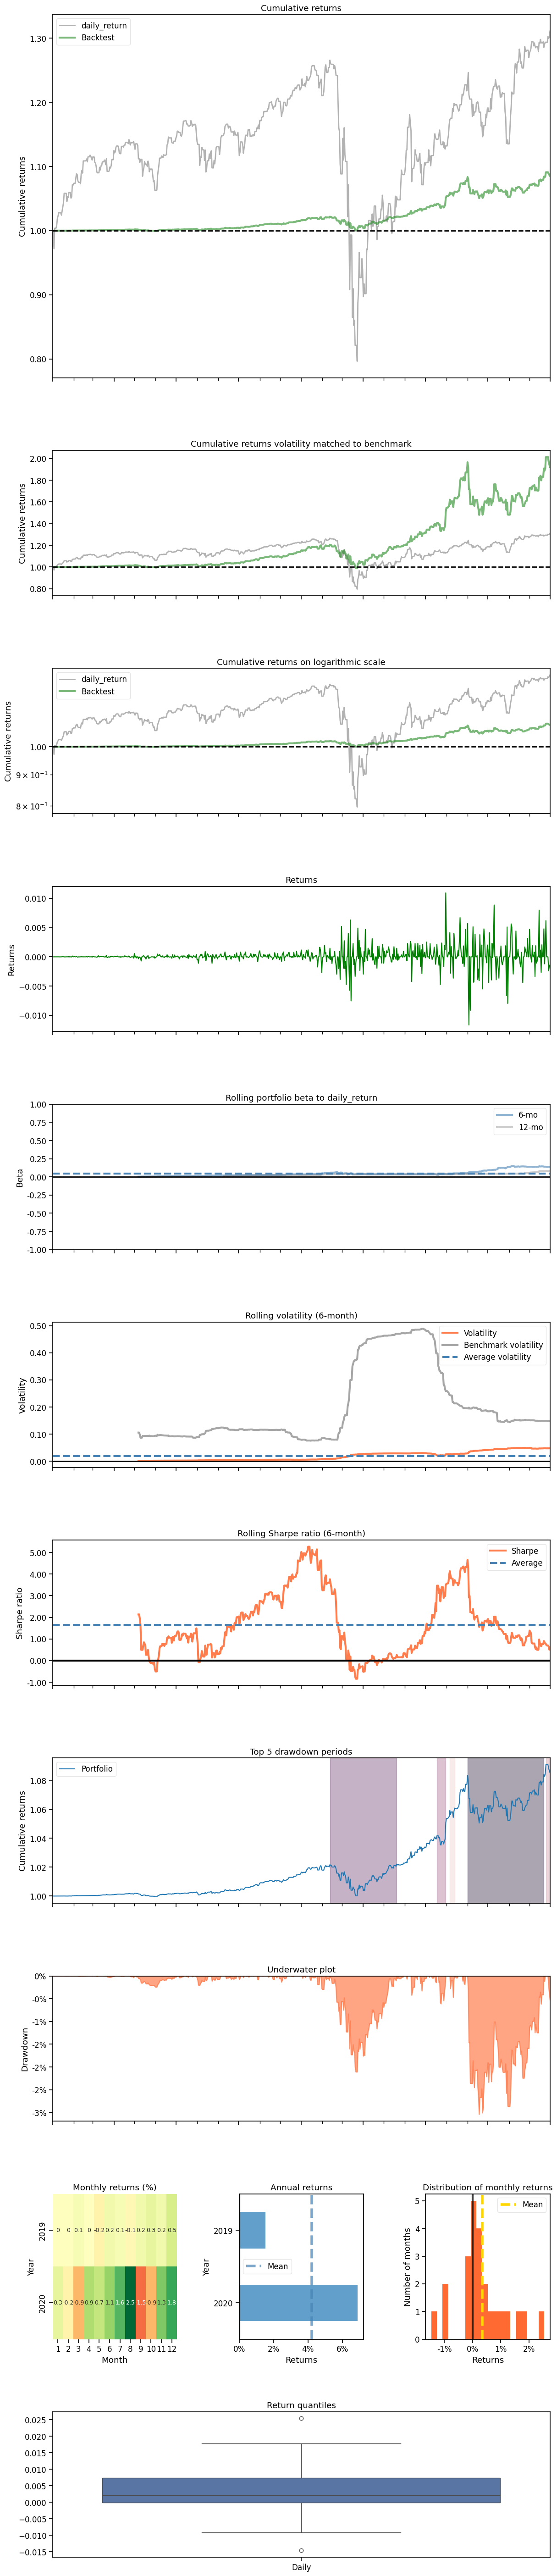

In [81]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

backtest_plot(df_account_value_ppo, 
            baseline_ticker = '^DJI', 
            baseline_start = TEST_START_DATE,
            baseline_end = TEST_END_DATE)

# backtest_plot(df_account_value_ddpg, 
#               baseline_ticker = '^DJI', 
#               baseline_start = TEST_START_DATE,
#               baseline_end = TEST_END_DATE)

# backtest_plot(df_account_value_sac, 
#               baseline_ticker = '^DJI', 
#               baseline_start = TEST_START_DATE,
#               baseline_end = TEST_END_DATE)

# if if_using_td3:
#   backtest_plot(df_account_value_td3, 
#               baseline_ticker = '^DJI', 
#               baseline_start = TEST_START_DATE,
#               baseline_end = TEST_END_DATE)

# if if_using_a2c:
#   backtest_plot(df_account_value_a2c, 
#               baseline_ticker = '^DJI', 
#               baseline_start = TEST_START_DATE,
#               baseline_end = TEST_END_DATE)

### Compare to Buy&Hold Strategy
pass in df_account_value, this information is stored in env class

<a id='6.2'></a>
## 7.2 BackTest with Buy&Hold Strategy

In [82]:
#baseline stats
print("==============Get Baseline Stats===========")
df_hold_ = get_baseline(
        ticker="AAPL", 
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(df_hold_, value_col_name = 'close')

[*********************100%%**********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (505, 8)
Annual return          0.852699
Cumulative returns     2.440902
Annual volatility      0.378310
Sharpe ratio           1.824544
Calmar ratio           2.713246
Stability              0.938857
Max drawdown          -0.314273
Omega ratio            1.409879
Sortino ratio          2.725805
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.114938
Daily value at risk   -0.044924
dtype: float64


In [83]:
df_hold_.date = pd.to_datetime(df_hold_['date'])
df_hold_ = pd.merge(df_account_value_ppo['date'],df_hold_,how='left')
df_hold_.bfill(inplace=True)
df_hold_

,date,open,high,low,close,volume,tic,day
0,2019-01-01,38.722500,39.712502,38.557499,37.845039,148158800.0,AAPL,2.0
1,2019-01-02,38.722500,39.712502,38.557499,37.845039,148158800.0,AAPL,2.0
2,2019-01-03,35.994999,36.430000,35.500000,34.075394,365248800.0,AAPL,3.0
3,2019-01-04,36.132500,37.137501,35.950001,35.530048,234428400.0,AAPL,4.0
4,2019-01-05,37.174999,37.207500,36.474998,35.450970,219111200.0,AAPL,0.0
...,...,...,...,...,...,...,...,...
726,2020-12-27,133.990005,137.339996,133.509995,134.146667,124486200.0,AAPL,0.0
727,2020-12-28,133.990005,137.339996,133.509995,134.146667,124486200.0,AAPL,0.0
728,2020-12-29,138.050003,138.789993,134.339996,132.360489,121047300.0,AAPL,1.0
729,2020-12-30,135.580002,135.990005,133.399994,131.231903,96452100.0,AAPL,2.0


In [84]:
df_hold = pd.DataFrame()
df_hold['date'] = df_account_value_ppo['date']
df_hold['hold'] = df_hold_['close'] / df_hold_['close'][0] * env_kwargs["initial_amount"]
# print("df_hold: ", df_hold)
# df_dji.to_csv("df_dji.csv")
df_hold = df_hold.set_index(df_hold.columns[0])
print("df_hold: ", df_hold)
# df_hold.to_csv("df_dji+.csv")

# df_account_value.to_csv('df_account_value.csv')

df_hold:                      hold
date                    
2019-01-01  1.000000e+06
2019-01-02  1.000000e+06
2019-01-03  9.003926e+05
2019-01-04  9.388297e+05
2019-01-05  9.367402e+05
...                  ...
2020-12-27  3.544630e+06
2020-12-28  3.544630e+06
2020-12-29  3.497433e+06
2020-12-30  3.467612e+06
2020-12-31  3.440902e+06

[731 rows x 1 columns]


==============Compare to Buy&Hold===========
result:                     stock          hold
date                                  
2019-01-01  1.000000e+06  1.000000e+06
2019-01-02  9.999999e+05  1.000000e+06
2019-01-03  9.999848e+05  9.003926e+05
2019-01-04  9.999934e+05  9.388297e+05
2019-01-05  9.999927e+05  9.367402e+05
...                  ...           ...
2020-12-27  1.091051e+06  3.544630e+06
2020-12-28  1.091051e+06  3.544630e+06
2020-12-29  1.088450e+06  3.497433e+06
2020-12-30  1.086805e+06  3.467612e+06
2020-12-31  1.085328e+06  3.440902e+06

[731 rows x 2 columns]


<Figure size 1500x500 with 0 Axes>

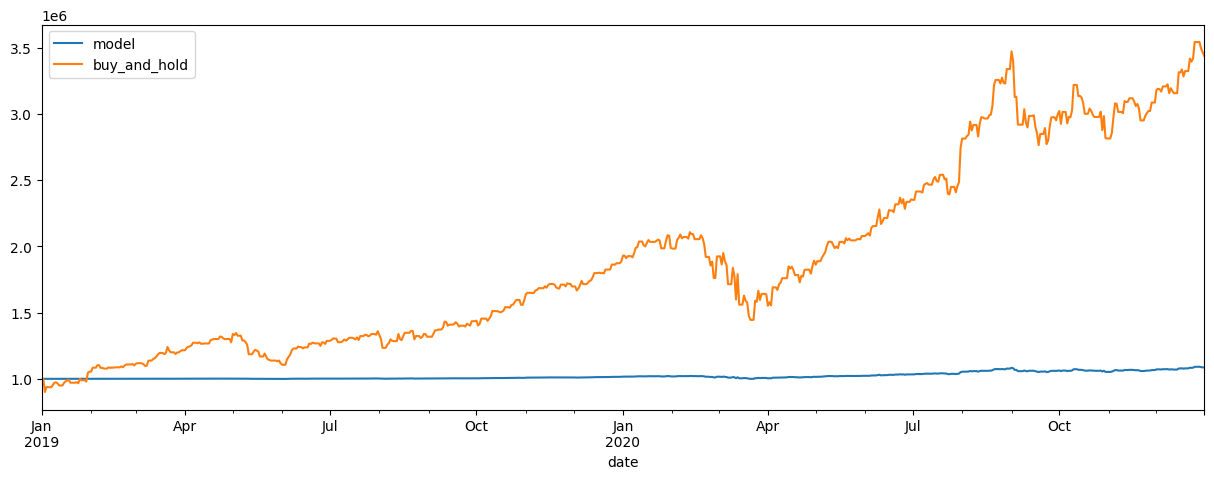

In [85]:
print("==============Compare to Buy&Hold===========")
df_result = pd.DataFrame({'date': df_account_value_ppo['date'], 'stock': df_account_value_ppo['account_value']})
df_result = df_result.set_index('date')

result = pd.DataFrame()
result = pd.merge(df_result, df_hold, left_index=True, right_index=True)
print("result: ", result)
# result.to_csv("result.csv")
result.columns = ['model', 'buy_and_hold']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();